## Suppl. Fig.3 Organellar co-enrichment in all IPs

In [1]:
import os, sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ggplot')
plt.rcParams['pdf.fonttype'] = 42
import seaborn as sns

script_path = Path.cwd().parent.parent.parent / "script"
data_path = Path.cwd().parent.parent.parent / "data"
sys.path.append(str(script_path))

from utils.label_processing import attach_annotations

### Load the volcano table

In [2]:
%store -r timestamp
print(f"Timestamp: {timestamp}")

Timestamp: 2023-10-21-imp5-for-figures


In [3]:
# define files to load
enrichment_dir = Path.cwd().parent.parent / "enrichment"
volcano_csv_path = enrichment_dir / "output" / "enrichment_and_volcano_tables" / f"{timestamp}_volcano_table.csv"

try:
    # load the file
    volcano = pd.read_csv(volcano_csv_path, header=[0, 1], index_col=0)
except FileNotFoundError:
    print(f"File {volcano_csv_path} not found.\nPlease run the enrichment analysis first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {volcano_csv_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [4]:
# attach canonical gene names
gene_name_csv = data_path / "external" / "canonical_names_and_Itzhak_data.csv"

lookup_table = pd.read_csv(gene_name_csv)
to_df = volcano["metadata"].copy()
list_of_cols_to_add = reversed(["Gene_name_canonical"])
for c in list_of_cols_to_add:
    new_col_data = attach_annotations(from_df=lookup_table, to_df=to_df, anno_col=c , from_on="Majority protein IDs", to_on="Majority protein IDs")
    volcano[("metadata", "Gene_name_canonical")] = new_col_data

# attach ground truth
ground_truth_csv = data_path / "external" / "curated_ground_truth_v9.0.csv"

lookup_table = pd.read_csv(ground_truth_csv)
to_df = volcano["metadata"].copy()
list_of_cols_to_add = reversed(["compartment"])
for c in list_of_cols_to_add:
    new_col_data = attach_annotations(from_df=lookup_table, to_df=to_df, anno_col=c, from_on="gene_name_canonical", to_on="Gene_name_canonical")
    volcano[("metadata", "curated_ground_truth_v9.0")] = new_col_data


In [5]:
# define output directory
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Split the pvals and enrichments into two dataframes

In [6]:
sample_cols = [i for i in volcano.columns if i[0].startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9"))]

In [7]:
# p-value dataframe
pval = volcano.copy()
for col in sample_cols:
    if col[1] == "enrichment":
        pval.drop(col, axis=1, inplace=True)

# rename the columns so that pval becomes the sample name (prepare for level drop)
new_column_names = [(i[0], i[0]) if i[1] == "pvals" else (i[0], i[1]) for i in pval.columns]
pval.columns = pd.MultiIndex.from_tuples(new_column_names)
pval = pval.droplevel(0, axis=1)

# construct an enrichment dataframe
enrichment = volcano.copy()
for col in sample_cols:
    if col[1] == "pvals":
        enrichment.drop(col, axis=1, inplace=True)

# rename the columns so that enrichment becomes the sample name (prepare for level drop)
new_column_names = [
    (i[0], i[0]) if i[1] == "enrichment" else (i[0], i[1]) for i in enrichment.columns
]
enrichment.columns = pd.MultiIndex.from_tuples(new_column_names)
enrichment = enrichment.droplevel(0, axis=1)

In [8]:
# drop WT columns
for col in enrichment.columns:
    if "WT" in col:
        enrichment.drop(col, axis=1, inplace=True)
        pval.drop(col, axis=1, inplace=True)

### For insignificant p-vals convert the enrichment value to 0

In [9]:
samples = sorted([i for i in enrichment.columns if i.startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")) and "WT" not in i])

In [10]:
enrichment_masked = enrichment.copy()

# uncomment the following lines to enable p-value filtering and negative enrichment filtering

# for col in samples:
#     mask = pval[col] < 1.301  # set the values to 0 if pval > 0.05
#     enrichment_masked.loc[mask, col] = 0  # set the values to NA if pval > 0.05

#     mask2 = enrichment[col] < 0
#     enrichment_masked.loc[mask2, col] = 0  # set the values to 0 if enrichment < 0

### Subset the dataframe to only include ground truth genes

In [11]:
# subset the umap table to remove rows with nan values in the ground truth labels
def subset_df(df):
    assert "curated_ground_truth_v9.0" in df.columns, "organelle column not found"

    # convert organelle labels to integers
    unique_strings = list(set(df["curated_ground_truth_v9.0"]))  # Get unique strings
    str_to_int_mapping = {string: index for index, string in enumerate(unique_strings)}  # Create a mapping from strings to unique integers
    org_label_data = [
        str_to_int_mapping[s] if not pd.isna(s) else s
        for s in df["curated_ground_truth_v9.0"]
    ]  # convert the list of strings to a list of integers
    org_GT = np.array(org_label_data)

    # get non-NAN indices
    org_GT_non_nan_idx = np.nonzero(~np.isnan(org_GT))[0]

    # subset the umap table to remove rows with nan values in the ground truth labels
    df_org_GT = df.iloc[list(org_GT_non_nan_idx)]

    return df_org_GT

In [12]:
enrich_org_GT = subset_df(enrichment_masked)
pval_org_GT = subset_df(pval)

### Get averaged enrichment values for each organelle

In [13]:
averaged_enrich_values = []
for i in sorted(samples):
    averaged_enrich_values.append(
        enrich_org_GT.groupby("curated_ground_truth_v9.0")[i].mean()
    )

co_enrich_df = pd.DataFrame(averaged_enrich_values)

### Plotting

In [14]:
co_enrich_df.columns

Index(['ER', 'ERGIC', 'Golgi', 'actin-binding_protein', 'centrosome',
       'cytosol', 'early_endosome', 'lysosome', 'mitochondria', 'nuclear_pore',
       'nucleus', 'p-body', 'peroxisome', 'plasma membrane', 'ribosome',
       'stress granule'],
      dtype='object', name='curated_ground_truth_v9.0')

In [15]:
# select a subset of samples
to_keep = ["12-YWHAQ","12-ACTB","09-ATG101","17-MAP1LC3B","11-CEP350","10-VPS35","07-CLTA","11-EEA1","05-NCLN",
"06-CCDC47","12-RTN4","12-SEC61B","02-COPE","03-SEC23A","11-SEC31A","14-RAB1A","07-COG8","11-GPR107",
"13-GOLGA2","03-HSPA1B","09-HSP90AA1","12-LAMP1","14-RAB7A","12-TOMM20","02-DCP1A","05-EDC4","09-PEX3",
"05-CAV1","17-ATP1B3","17-SLC30A2","09-PSMB7","13-RAB14","14-RAB11A","17-RPL36","17-CAPRIN1","17-G3BP1",'06-YWHAB']

co_enrich_df = co_enrich_df.loc[to_keep, :]

# select a subset of compartments and enforce order
orgs = [
    "centrosome",
    "ribosome",
    "stress granule",
    "p-body",
    "plasma membrane",
    "early_endosome",
    "lysosome",
    "Golgi",
    # "ERGIC",
    "ER",
    "peroxisome",
    "mitochondria",
]

co_enrich_df = co_enrich_df[orgs]

In [16]:
print(f"Number of IPs: {len(to_keep)}")

Number of IPs: 37


In [17]:
# manually define an order
sample_order = ['11-CEP350',
                '17-RPL36',
                '17-CAPRIN1',
                '17-G3BP1',
                '05-EDC4',
                '02-DCP1A',
                '17-ATP1B3',
                '17-SLC30A2',
                '11-EEA1',
                '10-VPS35',
                '12-LAMP1',
                '13-GOLGA2',
                '11-GPR107',
                '07-COG8',
                '11-SEC31A',
                '03-SEC23A',
                '02-COPE',
                '12-RTN4',
                '05-NCLN',
                '12-SEC61B',
                '09-PEX3',
                '12-TOMM20',
                '14-RAB7A',
                '14-RAB11A',
                '13-RAB14',
                '14-RAB1A',
                '05-CAV1',
                '09-ATG101',
                '17-MAP1LC3B',
                '09-HSP90AA1',
                '03-HSPA1B',
                '12-ACTB',
                '09-PSMB7',
                '07-CLTA',
                '06-YWHAB',
                '12-YWHAQ',
 ]

# apply order of samples
df_plot = co_enrich_df[orgs]
df_plot = df_plot.loc[sample_order]

In [18]:
# clip the values below 0
df_plot = df_plot.clip(lower=0)
# save plot data to file
df_plot.to_csv("output/Fig_1L_extended.csv")

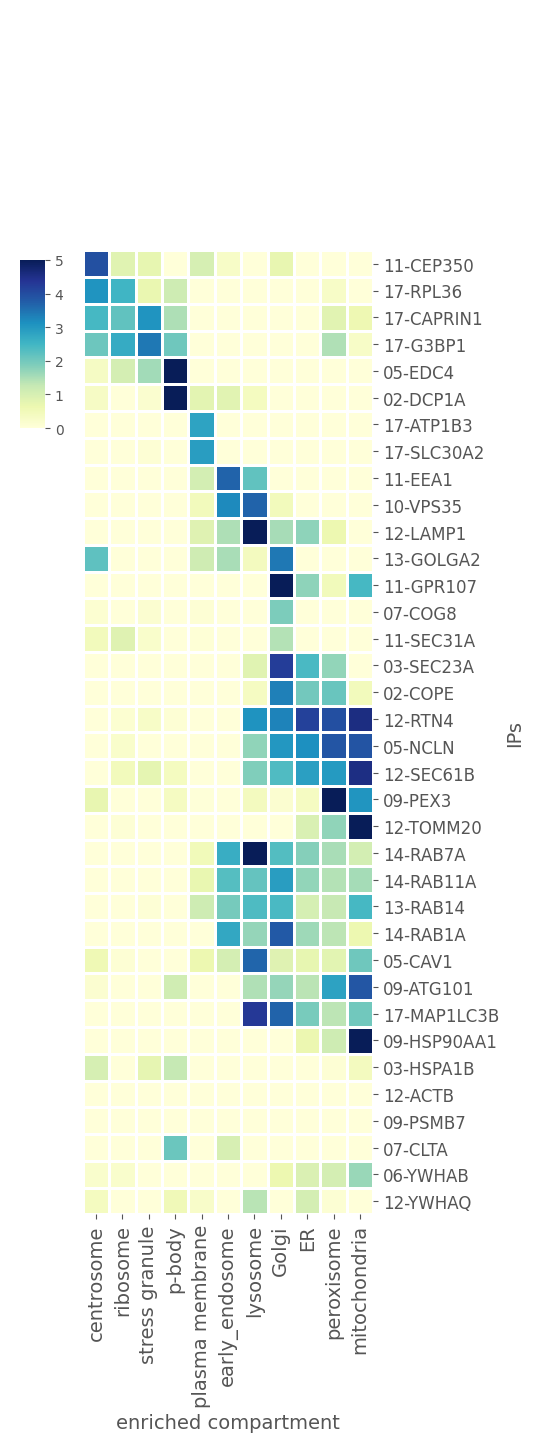

In [19]:
df_plot.fillna(0, inplace=True)
g = sns.clustermap(
    df_plot,
    figsize=(5, 14), col_cluster=False, row_cluster=False, standard_scale=None,
    #z_score=0,  # 0 means row-wise z-score,
    vmax = 5, # clip values above 5
    vmin = 0, # clip values below 0
    cmap="YlGnBu", linecolor="white", linewidths=2,
    cbar_pos=(0.05, 0.69, 0.05, 0.12)  # Adjust this to position the color bar: left, bottom, width, height
)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=14)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=12)
g.ax_heatmap.set_xlabel("enriched compartment", fontsize=14)
g.ax_heatmap.set_ylabel("IPs", fontsize=14)

plt.savefig(os.path.join(output_dir, "co-enrichment.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(output_dir, "co-enrichment.svg"), bbox_inches="tight")